# Autoencoder Model Development - Experimental
Notebook below contains development code for building a TensorFlow/Keras autoencoder to detect anomalies in manufacturing telemetry data.

<b>Note: To run this notebook select and activate the Python 3.8 Pytorch and Tensorflow kernel from your AML Compute Instance</b>

### Import required packages and connect to AML workspace

In [3]:
import pandas as pd
from azureml.core import Workspace
from databricks import sql as dbsql 

import mlflow
from mlflow import pyfunc

from azureml.core import Workspace, Model
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
import joblib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

ws = Workspace.from_config()
kv = ws.get_default_keyvault()

### Load and prep data from Databricks
Using the same logic/routine developed in our Exploratory Data Analysis

In [2]:
pat = kv.get_secret('dbxpat') # Personal Access Token
http_path = kv.get_secret('dbxhttppath') # Databricks Table HTTP Path
server_hostname = kv.get_secret('dbxservername') # Databricks server name

# Configuration variables - from your keyvault and Databricks 
databricks_pat = pat
server_hostname = server_hostname
http_path = http_path
 
# Define the connection to the SQL endpoint 
connection = dbsql.connect( 
    server_hostname = server_hostname,
    http_path = http_path,
    access_token = databricks_pat
)
 
# Represent the query as a string 
sql_query = "SELECT * FROM default.mfg001" 
 
# Execute the query 
with connection.cursor() as cursor: 
# Get the data 
    cursor.execute(sql_query) 
    data = cursor.fetchall() 
    cursor.execute("SHOW COLUMNS IN default.mfg001") 
    columns = cursor.fetchall() 

columns = [column[0] for column in columns] 
df = pd.DataFrame(data=data, columns=columns)

df.dropna(inplace=True)

### Define Autoencoder

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(49, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

### Separate and Scale Data
Data has tags added indicating `NORMAL` or `BROKEN`/`RECOVERING`. Separate the latter two categories into their own subset

In [5]:
good_data = df[df['machine_status']=='NORMAL']
bad_data = df[df['machine_status']!='NORMAL']

full_data_good = good_data.drop(columns=['timestamp', 'machine_status'])
full_data_bad = bad_data.drop(columns=['timestamp', 'machine_status'])

scaler = MinMaxScaler()
scaler.fit(full_data_good)
full_data_good = scaler.transform(full_data_good)
full_data_bad  = scaler.transform(full_data_bad)

train_data, test_data = train_test_split(
    full_data_good, test_size=0.15, random_state=21
)

#Save scaler to disk
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

### Train Model and log using MLflow
Code below trains our Autoencoder and logs results directly into the AML workspace using MLflow. Additional artifacts (model scaler and thresholds) are added as artifacts.

We can view the results of our run in the AML workspace. Autologging includes all metrics and parameters.

In [6]:
import mlflow.tensorflow
mlflow.tensorflow.autolog(every_n_iter=1)

mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
mlflow.set_experiment('MODEL_DEV_AUTOENCODER')

model_name = 'DEV_anomaly_detector'

# Start the run
with mlflow.start_run(run_name='DEV_autoencoder_run') as run:
    run_id = run.info.run_id
    history = autoencoder.fit(train_data, train_data, 
          epochs=100, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)
    mlflow.log_artifact('scaler.pkl')
    model_uri = mlflow.get_artifact_uri("model")
    
    reconstructions = autoencoder.predict(train_data)
    train_loss = tf.keras.losses.mae(reconstructions, train_data)
    sd = np.std(train_loss[None,:])
    threshold = np.median(train_loss[None,:]) + (3*sd)
    with open('./threshold.txt', 'w') as file:
        file.write(str(threshold))
    mlflow.log_artifact('threshold.txt')

2022/10/04 15:00:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Epoch 1/100
341/341 [==============================] - 2s 4ms/step - loss: 0.0936 - val_loss: 0.0483
Epoch 2/100
341/341 [==============================] - 1s 2ms/step - loss: 0.0394 - val_loss: 0.0347
Epoch 3/100
341/341 [==============================] - 1s 2ms/step - loss: 0.0332 - val_loss: 0.0327
Epoch 4/100
341/341 [==============================] - 1s 2ms/step - loss: 0.0322 - val_loss: 0.0317
Epoch 5/100
341/341 [==============================] - 1s 2ms/step - loss: 0.0314 - val_loss: 0.0311
Epoch 6/100
341/341 [==============================] - 1s 2ms/step - loss: 0.0310 - val_loss: 0.0307
Epoch 7/100
341/341 [==============================] - 1s 2ms/step - loss: 0.0301 - val_loss: 0.0295
Epoch 8/100
341/341 [==============================] - 1s 2ms/step - loss: 0.0294 - val_loss: 0.0290
Epoch 9/100
341/341 [==============================] - 1s 2ms/step - loss: 0.0290 - val_loss: 0.0288
Epoch 10/100
341/341 [==============================] - 1s 3ms/step - loss: 0.0287 - val_lo

2022/10/04 15:01:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils."


5448/5448 [==============================] - 4s 713us/step


2022-10-04 15:01:27.837732: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 68328344 exceeds 10% of free system memory.
2022-10-04 15:01:27.898893: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 68328344 exceeds 10% of free system memory.
2022-10-04 15:01:27.922182: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 68328344 exceeds 10% of free system memory.
2022-10-04 15:01:27.938521: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 68328344 exceeds 10% of free system memory.


### Plot train/test losses across epochs

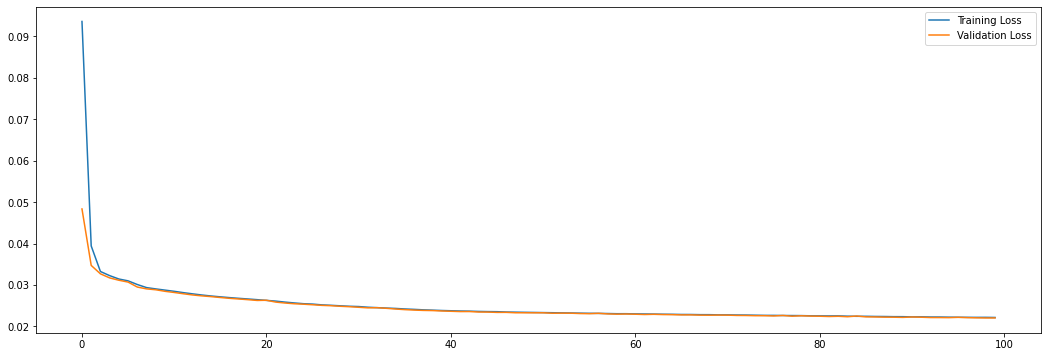

In [7]:
plt.figure(figsize=(18,6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

### Plot reconstruction losses for Training Data

5448/5448 [==============================] - 4s 716us/step


2022-10-04 15:09:57.967271: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 68328344 exceeds 10% of free system memory.


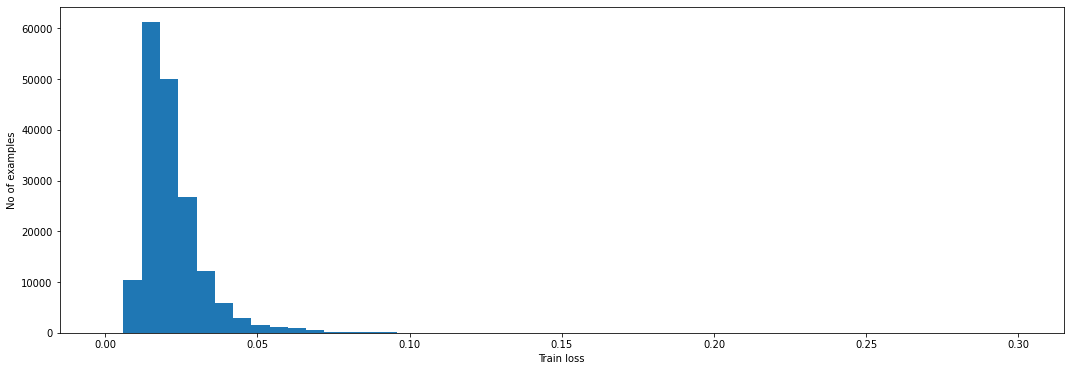

In [8]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.figure(figsize=(18,6))
plt.hist(train_loss[None,:], bins=50, range=(0,.3))
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

### Plot reconstructions for Holdout/Validation data

117/117 [==============================] - 0s 727us/step


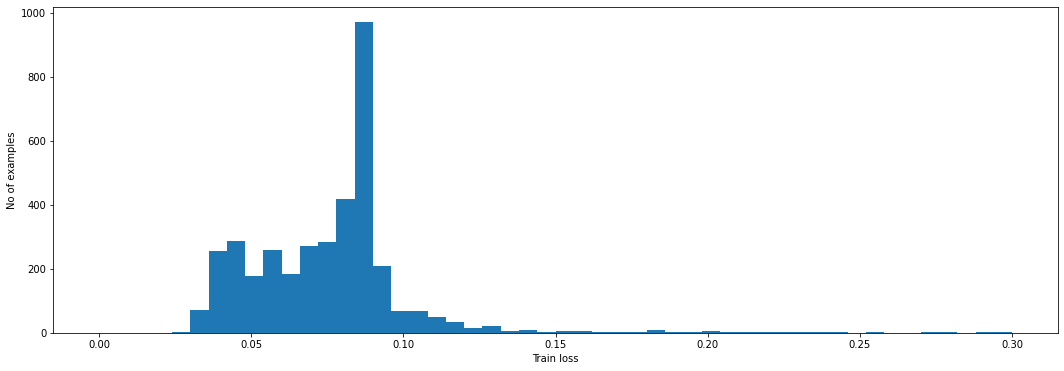

In [10]:
holdout_data = bad_data.drop(columns=['timestamp', 'machine_status'])

holdout_data = scaler.transform(holdout_data)
holdout_data

holdout_data = tf.cast(holdout_data, tf.float32)

reconstructions = autoencoder.predict(holdout_data)
holdout_loss = tf.keras.losses.mae(reconstructions, holdout_data)

plt.figure(figsize=(18,6))
plt.hist(holdout_loss[None,:], bins=50,  range=(0,.3))
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

### Calculate Threshold for Anomaly Detection
By default we set the threshold to 3 standard deviations above the median of calculated reconstruction losses over our training set

In [11]:
sd = np.std(train_loss[None,:])
threshold = np.median(train_loss[None,:]) + (3*sd)
threshold

0.05070944878224933

### Plot reconstruction losses for Training data & Validation data along with threshold

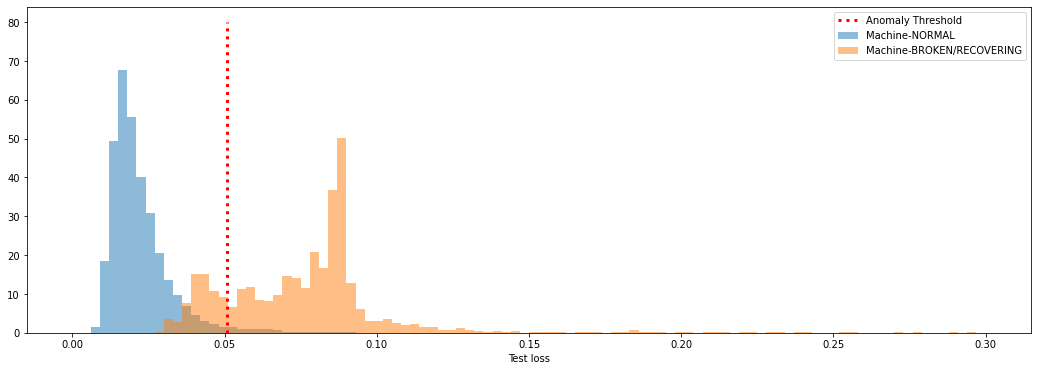

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6))
plt.hist(train_loss[None,:], bins=100, density=True, alpha=.5, range=(0,.3))
plt.hist(holdout_loss[None,:], bins=100, density=True, alpha=.5,  range=(0,.3))
plt.plot([threshold, threshold], [0, 80], c='red', linewidth=3,linestyle='dotted')
plt.legend(['Anomaly Threshold', 'Machine-NORMAL', 'Machine-BROKEN/RECOVERING'])
plt.xlabel("Test loss")
plt.ylabel("")
plt.show()